In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cat
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import QuantileTransformer

In [3]:
matches = pd.read_pickle('../Resources/tennis_clean/atp_matches_full_feature.pkl').reset_index()

In [4]:
CAREER_COLUMNS = ['career_first_serve_percentage',
                  'career_first_serves_won_percentage',
                  'career_second_serves_won_percentage',
                  'career_service_points_won_percentage',
                  'career_break_points_saved_percentage',
                  'career_break_points_won_percentage',
                  'career_first_serve_return_points_won_percentage',
                  'career_second_serve_return_points_won_percentage',
                  'career_return_points_won_percentage',
                  'career_points_won_percentage',
                  'career_ace_rate',
                  'career_double_fault_rate']


CAREER_COLUMNS += [column + '_opponent' for column in CAREER_COLUMNS]

In [5]:
EWMA_10_COLUMNS = ['ewma_10_first_serve_percentage',
                   'ewma_10_first_serves_won_percentage',
                   'ewma_10_second_serves_won_percentage',
                   'ewma_10_service_points_won_percentage',
                   'ewma_10_break_points_saved_percentage',
                   'ewma_10_break_points_won_percentage',
                   'ewma_10_first_serve_return_points_won_percentage',
                   'ewma_10_second_serve_return_points_won_percentage',
                   'ewma_10_return_points_won_percentage',
                   'ewma_10_points_won_percentage',
                   'ewma_10_ace_rate',
                   'ewma_10_double_fault_rate']

EWMA_10_COLUMNS += [column + '_opponent' for column in EWMA_10_COLUMNS]

In [6]:
EWMA_50_COLUMNS = ['ewma_50_first_serve_percentage',
                   'ewma_50_first_serves_won_percentage',
                   'ewma_50_second_serves_won_percentage',
                   'ewma_50_service_points_won_percentage',
                   'ewma_50_break_points_saved_percentage',
                   'ewma_50_break_points_won_percentage',
                   'ewma_50_first_serve_return_points_won_percentage',
                   'ewma_50_second_serve_return_points_won_percentage',
                   'ewma_50_return_points_won_percentage',
                   'ewma_50_points_won_percentage',
                   'ewma_50_ace_rate',
                   'ewma_50_double_fault_rate']

EWMA_50_COLUMNS += [column + '_opponent' for column in EWMA_50_COLUMNS]

In [7]:
OTHER_COLUMNS = ['ranking_points_diff', 'rank_diff', 'player_age', 'opponent_age', 'result_value']

In [8]:
COLUMNS = CAREER_COLUMNS + EWMA_10_COLUMNS + EWMA_50_COLUMNS + OTHER_COLUMNS

In [9]:
train = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2021')][COLUMNS]
test = matches[matches['tournament_date'] > '2021'][COLUMNS]

In [10]:
X_train = train.drop('result_value', axis=1)
y_train = train['result_value']

X_test = test.drop('result_value', axis=1)
y_test = test['result_value']

In [14]:
def objective_cb(trial):
    params = {
        'objective': 'Logloss',
        'thread_count': -1,
        'num_trees': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1.0, 5.0),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
    }
    
    cb = cat.CatBoostClassifier(**params)
    
    score = cross_val_score(cb, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    log_loss = score.mean()
    return log_loss

In [15]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective_cb, n_trials=100)
# print(study.best_trial, study.best_params)

[I 2021-08-31 09:28:46,009] A new study created in memory with name: no-name-6051ac4f-1fa7-4c2b-b074-dceab8373aa5
[I 2021-08-31 09:30:22,244] Trial 0 finished with value: 0.6282421066177444 and parameters: {'learning_rate': 0.09454923566938168, 'l2_leaf_reg': 2.875008720260862, 'random_strength': 2.9471054057995008, 'max_depth': 8}. Best is trial 0 with value: 0.6282421066177444.
[I 2021-08-31 09:31:06,544] Trial 1 finished with value: 0.6410363427983151 and parameters: {'learning_rate': 0.06240662703463925, 'l2_leaf_reg': 6.650991870463054, 'random_strength': 4.304221179859187, 'max_depth': 6}. Best is trial 1 with value: 0.6410363427983151.
[I 2021-08-31 09:32:39,428] Trial 2 finished with value: 0.6311810685498451 and parameters: {'learning_rate': 0.07361385810896413, 'l2_leaf_reg': 1.199675689308789, 'random_strength': 4.211163950504043, 'max_depth': 8}. Best is trial 1 with value: 0.6410363427983151.
[I 2021-08-31 09:33:41,435] Trial 3 finished with value: 0.6618208502765659 and p

KeyboardInterrupt: 

In [28]:
best_params_cb = {
    'objective': 'Logloss',
    'thread_count': -1,
    'num_trees': 500,
    'l2_leaf_reg': 1.66,
    'random_strength': 3,
    'max_depth': 8,
}

cb = cat.CatBoostClassifier(**best_params_cb).fit(X_train, y_train)

0:	learn: 0.6884035	total: 38.7ms	remaining: 19.3s
1:	learn: 0.6840920	total: 72.9ms	remaining: 18.2s
2:	learn: 0.6799712	total: 109ms	remaining: 18s
3:	learn: 0.6761110	total: 145ms	remaining: 17.9s
4:	learn: 0.6720788	total: 175ms	remaining: 17.3s
5:	learn: 0.6689592	total: 208ms	remaining: 17.2s
6:	learn: 0.6658486	total: 241ms	remaining: 17s
7:	learn: 0.6631435	total: 278ms	remaining: 17.1s
8:	learn: 0.6601455	total: 312ms	remaining: 17s
9:	learn: 0.6572799	total: 342ms	remaining: 16.8s
10:	learn: 0.6543779	total: 374ms	remaining: 16.6s
11:	learn: 0.6517141	total: 407ms	remaining: 16.6s
12:	learn: 0.6490349	total: 440ms	remaining: 16.5s
13:	learn: 0.6467608	total: 474ms	remaining: 16.5s
14:	learn: 0.6445206	total: 506ms	remaining: 16.4s
15:	learn: 0.6422268	total: 538ms	remaining: 16.3s
16:	learn: 0.6405333	total: 572ms	remaining: 16.2s
17:	learn: 0.6385924	total: 602ms	remaining: 16.1s
18:	learn: 0.6367788	total: 636ms	remaining: 16.1s
19:	learn: 0.6350044	total: 665ms	remaining: 

164:	learn: 0.5843191	total: 5.27s	remaining: 10.7s
165:	learn: 0.5842250	total: 5.3s	remaining: 10.7s
166:	learn: 0.5841149	total: 5.33s	remaining: 10.6s
167:	learn: 0.5839931	total: 5.37s	remaining: 10.6s
168:	learn: 0.5838931	total: 5.39s	remaining: 10.6s
169:	learn: 0.5837725	total: 5.42s	remaining: 10.5s
170:	learn: 0.5836735	total: 5.45s	remaining: 10.5s
171:	learn: 0.5835826	total: 5.48s	remaining: 10.5s
172:	learn: 0.5834836	total: 5.51s	remaining: 10.4s
173:	learn: 0.5833930	total: 5.54s	remaining: 10.4s
174:	learn: 0.5832872	total: 5.57s	remaining: 10.3s
175:	learn: 0.5831562	total: 5.59s	remaining: 10.3s
176:	learn: 0.5829991	total: 5.63s	remaining: 10.3s
177:	learn: 0.5828868	total: 5.66s	remaining: 10.2s
178:	learn: 0.5828060	total: 5.68s	remaining: 10.2s
179:	learn: 0.5827148	total: 5.71s	remaining: 10.2s
180:	learn: 0.5825535	total: 5.75s	remaining: 10.1s
181:	learn: 0.5824433	total: 5.78s	remaining: 10.1s
182:	learn: 0.5823550	total: 5.81s	remaining: 10.1s
183:	learn: 0

326:	learn: 0.5680045	total: 10.2s	remaining: 5.39s
327:	learn: 0.5679291	total: 10.2s	remaining: 5.36s
328:	learn: 0.5677849	total: 10.3s	remaining: 5.33s
329:	learn: 0.5677210	total: 10.3s	remaining: 5.3s
330:	learn: 0.5675826	total: 10.3s	remaining: 5.27s
331:	learn: 0.5674775	total: 10.3s	remaining: 5.23s
332:	learn: 0.5674091	total: 10.4s	remaining: 5.2s
333:	learn: 0.5673692	total: 10.4s	remaining: 5.17s
334:	learn: 0.5672944	total: 10.4s	remaining: 5.14s
335:	learn: 0.5671668	total: 10.5s	remaining: 5.11s
336:	learn: 0.5670503	total: 10.5s	remaining: 5.07s
337:	learn: 0.5669537	total: 10.5s	remaining: 5.04s
338:	learn: 0.5668377	total: 10.5s	remaining: 5.01s
339:	learn: 0.5667457	total: 10.6s	remaining: 4.98s
340:	learn: 0.5666300	total: 10.6s	remaining: 4.95s
341:	learn: 0.5665267	total: 10.6s	remaining: 4.91s
342:	learn: 0.5664134	total: 10.7s	remaining: 4.88s
343:	learn: 0.5662532	total: 10.7s	remaining: 4.85s
344:	learn: 0.5661461	total: 10.7s	remaining: 4.82s
345:	learn: 0.

486:	learn: 0.5499449	total: 14.8s	remaining: 395ms
487:	learn: 0.5498293	total: 14.8s	remaining: 364ms
488:	learn: 0.5496764	total: 14.8s	remaining: 334ms
489:	learn: 0.5495248	total: 14.9s	remaining: 303ms
490:	learn: 0.5494025	total: 14.9s	remaining: 273ms
491:	learn: 0.5492904	total: 14.9s	remaining: 243ms
492:	learn: 0.5491473	total: 15s	remaining: 212ms
493:	learn: 0.5490422	total: 15s	remaining: 182ms
494:	learn: 0.5489117	total: 15s	remaining: 152ms
495:	learn: 0.5487701	total: 15s	remaining: 121ms
496:	learn: 0.5486504	total: 15.1s	remaining: 91ms
497:	learn: 0.5485495	total: 15.1s	remaining: 60.7ms
498:	learn: 0.5484126	total: 15.1s	remaining: 30.3ms
499:	learn: 0.5482962	total: 15.2s	remaining: 0us


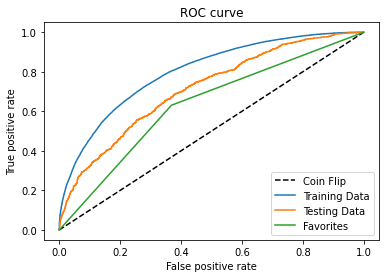

Train AUC: 0.7999988567675436
Test AUC: 0.7121957093024345
Favorite AUC: 0.6311162079510704

Test Accuracy: 0.6532874617737003
Test Accuracy: 0.6311162079510704


In [29]:
y_pred_train = cb.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)

y_pred_test = cb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_test)


plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
plt.plot(fpr_train, tpr_train, label='Training Data')
plt.plot(fpr, tpr, label='Testing Data')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')


higher_ranked = test.dropna(subset=COLUMNS).ranking_points_diff > 0
fpr_naive, tpr_naive, _ = roc_curve(y_test, higher_ranked.values)
plt.plot(fpr_naive, tpr_naive, label='Favorites')


plt.legend()
plt.show()

print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}')
print(f'Test AUC: {roc_auc_score(y_test, y_pred_test)}')
print(f'Favorite AUC: {roc_auc_score(y_test, higher_ranked)}')

print(f'\nTest Accuracy: {accuracy_score(y_test, cb.predict(X_test))}')
print(f'Test Accuracy: {accuracy_score(y_test, higher_ranked)}')